In [1]:
import os
import sys
basepath = '/' + os.path.join('Users', 'zach', 'Git', 'Masterarbeit', 'Project')
sys.path.append(basepath)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Enable full width output for numpy (https://stackoverflow.com/questions/43514106/python-terminal-output-width)
np.set_printoptions(suppress=True, linewidth=250, threshold=250)

from src.ml.training import load_model
from sklearn.pipeline import Pipeline
from src.d.transformators import TransformData, FindGradient, FindAngle, Rotate, CDS, HF, TwoLayers
from data.fortran_test.utils import get_predictions, plot_vofs, create_plot
from src.ml.building import custom_loss

Using TensorFlow backend.


param_str:
_mlp_1000_200-150-120_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_shift_kappa
Faktor:	-8.0
avg fortran:	0.2038726526079846
avg hier:	0.503748676809418



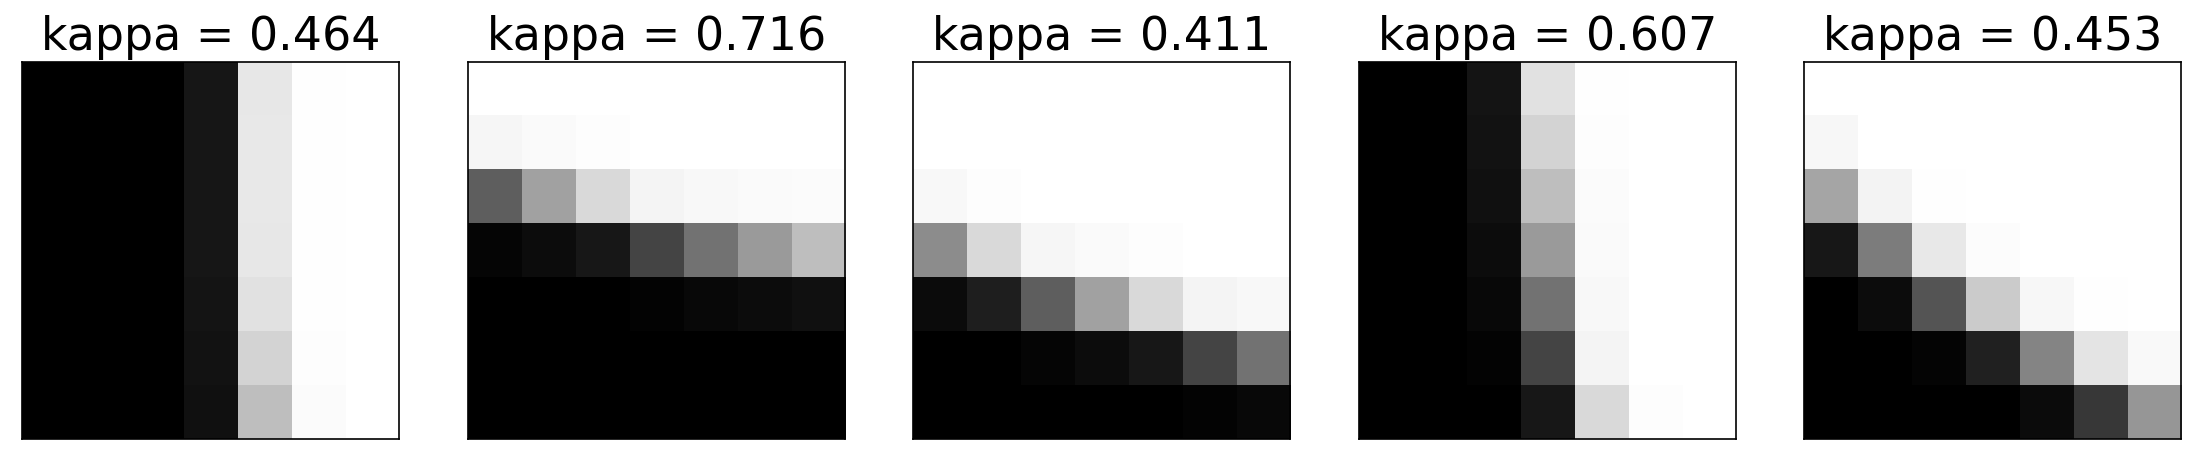

In [13]:
from sklearn.pipeline import Pipeline
from src.d.transformators import TransformData, FindGradient, FindAngle, Rotate, CDS, HF, TwoLayers
import subprocess
import re
gitter = 128
dt = 'all'
dtm = 'all'
c_nb = True  # Auch wenn Bedingung für Nachbarn nicht erfüllt ist 
folder = 'model_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_rot_'+dt+'_smr_nhc_'+str(gitter) + ('_allstc' if c_nb else '')
#model = '_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_rot_'+dtm+'_smr_nhc' + '_shift_kappa'
model = '_mlp_1000_200-150-120_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_shift_kappa'
scale = (1/4 if gitter == 32 else 1)
#folder = 'output_circle_128'
vector_c = pd.read_csv(os.path.join('/'+basepath, 'data', 'fortran_test', folder, 'output_c.txt'), skiprows=1, dtype=np.float).values
#vector_last = pd.read_csv(os.path.join('/'+basepath, 'data', 'fortran_test', folder, 'output_last.txt'), skiprows=1, dtype=np.float).values
#vector_last = np.reshape(vector_last, (vector_last.shape[0],))
vector_cm = pd.read_csv(os.path.join('/'+basepath, 'data', 'fortran_test', folder, 'output_cm.txt'), skiprows=1, dtype=np.float).values
vector_cm = np.nan_to_num(vector_cm)
vector_cds = pd.read_csv(os.path.join('/'+basepath, 'data', 'fortran_test', 'output_cds_'+str(gitter)+('.txt' if c_nb else '_nurc.txt')), skiprows=1, dtype=np.float).values[:, 0]
vector_last = get_predictions(vector_cm, basepath=basepath, filename=model, custom_object = {'custom_loss': custom_loss})

parameters = {'stencil_size': [7, 7], 'angle': False}
# Create pipeline
data_pipeline = Pipeline([
    ('transform', TransformData(parameters=parameters, reshape=False)),
    ('findgradient', FindGradient(parameters=parameters)),
    ('findangle', FindAngle(parameters=parameters)),
    ('rotate', Rotate(parameters=parameters)),  # Output: [labels, data, angle_matrix]
])
# Execute pipeline
pipe_c = np.reshape(np.flip(np.reshape(vector_c, (vector_c.shape[0], 7, 7)), axis=1), (vector_c.shape[0], 49))
#pipe_c = np.reshape(np.reshape(vector_c, (vector_c.shape[0], 7, 7)), (vector_c.shape[0], 49))
#pipe_c = np.reshape(vector_c, (vector_c.shape[0], 49))
pipe_c = np.concatenate((np.reshape(vector_last, (vector_last.shape[0], 1)), pipe_c), axis = 1)
pipe_c = pd.DataFrame(pipe_c)
[c_lab, c_feat, c_ang] = data_pipeline.fit_transform(pipe_c)


gitweit_selbst = 1/1000
gitweit_fnb = 8/gitter
faktor = -0.5*1/gitweit_fnb
print(f'Faktor:\t{faktor}')
vector_last = vector_last*faktor

# Get average curvature from fortran output file
kappa_path = os.path.join(basepath, 'data', 'fortran_test', folder, 'model*.txt')
avg_kappa = float(re.findall(r'\d\.\d+',str(subprocess.check_output(f'cat {kappa_path} | grep "Average"', shell=True)))[0])*scale
print(f'avg fortran:\t{avg_kappa}')
# Get average curvature calculated with fortran stencils
print(f'avg hier:\t{sum(vector_last)/len(vector_last)}')

if False:
    print(vector_cm.shape)
    #indices = np.where((vector_last > -0.5) & (vector_last < 1.25))
    indices = np.where((vector_last > 1.25))
    vector_c = vector_c[indices[0], :]
    vector_cm = vector_cm[indices[0], :]
    vector_last = vector_last[indices]
    c_feat = c_feat[indices]
    c_lab = c_lab[indices]
    print(vector_cm.shape)
else:
    # Get random values
    np.random.seed(42)
    indices = np.random.permutation(vector_c.shape[0])
    vector_c = vector_c[indices, :]
    vector_cm = vector_cm[indices, :]
    vector_last = vector_last[indices]
    c_feat = c_feat[indices]
    c_lab = c_lab[indices]


#plot_vofs(np.reshape(vector_c, (vector_c.shape[0],7,7)), 5, labels=vector_last, per_row=5)
plot_vofs(np.reshape(c_feat, (c_feat.shape[0],7,7)), 5, labels=c_lab*faktor, per_row=5)
#plot_vofs(np.reshape(c_feat, (c_feat.shape[0],7,7)), 1, per_row = 1, size=0.5)

(1273332, 49)



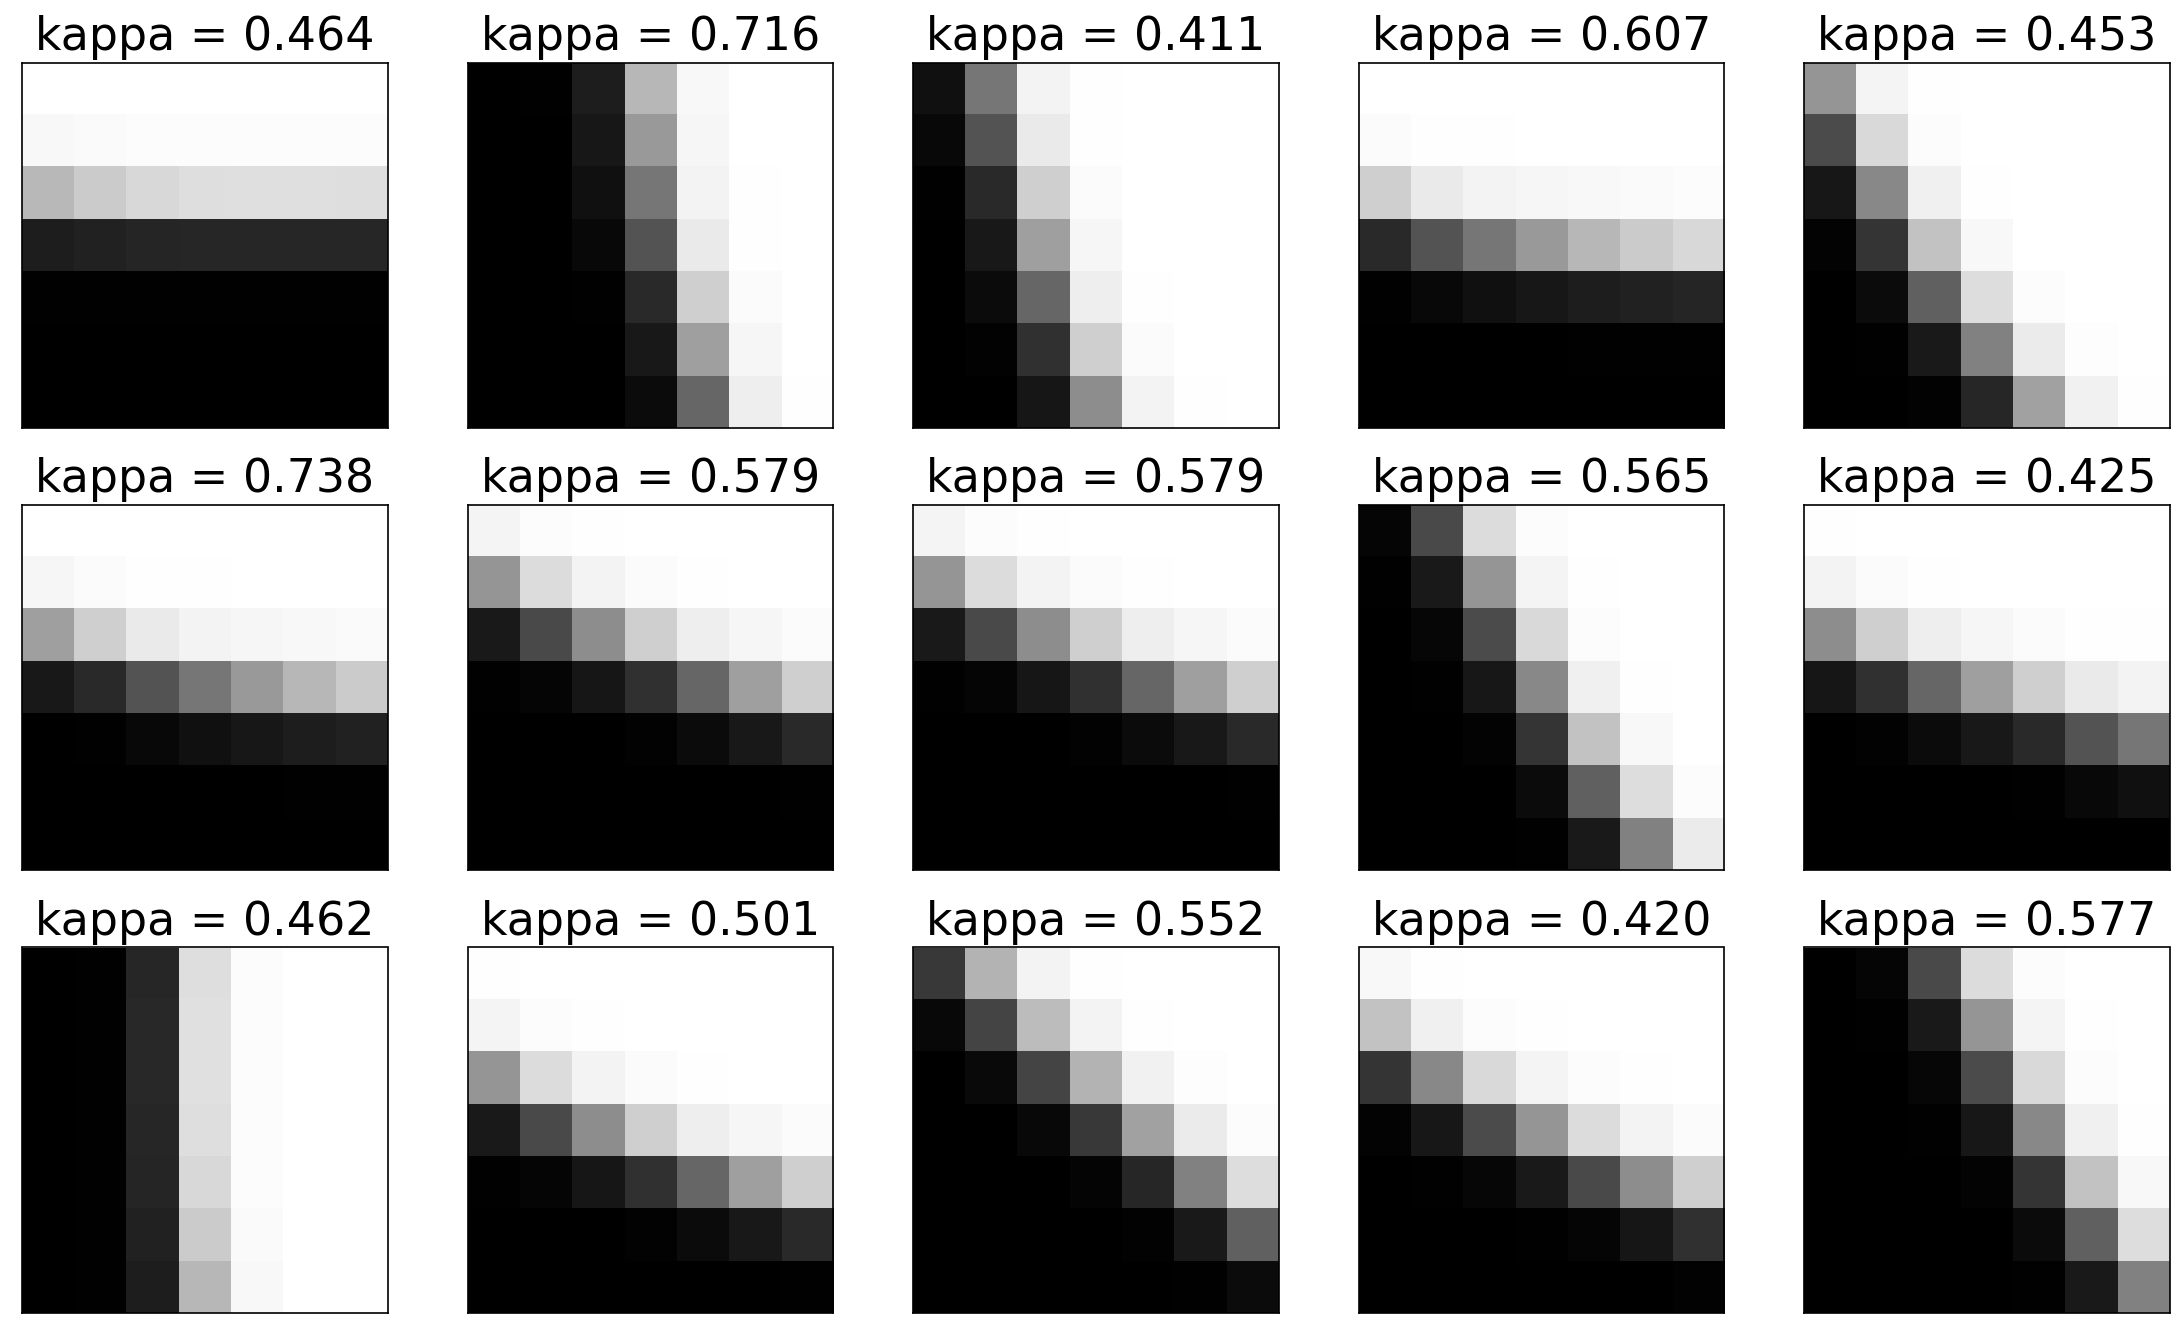

In [14]:
print(vector_cm.shape)
plot_vofs(np.reshape(vector_cm, (vector_cm.shape[0],7,7)), 15, labels=vector_last, per_row=5)

param_str:
_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_shift_kappa
param_str:
_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_shift_kappa

Mittelwert/Standardabweichung cm:	0.5015,	0.1374
Mittelwert/Standardabweichung c:	0.5292,	0.1483
Mittelwert/Standardabweichung cds:	0.4656,	0.1351


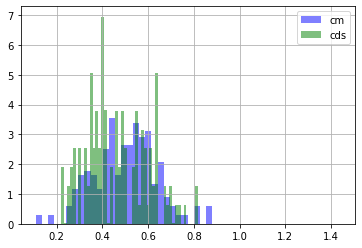

In [15]:
#dtm = 'circle'
#testmodel = '_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_rot_'+dtm+'_smr_nhc' + '_shift_kappa'
testmodel = '_mlp_1000_200-150-120_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_shift_kappa'
testmodel = '_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_shift_kappa'
custom_object = {'custom_loss': custom_loss}

fortran_predictions = get_predictions(vector_cm, basepath=basepath, filename=testmodel, custom_object=custom_object)*faktor  # vector_last*faktor # 
fortran_predictions_2 = get_predictions(c_feat, basepath=basepath, filename=testmodel, custom_object=custom_object)*faktor
idx = list(range(0,9))

print(f'\nMittelwert/Standardabweichung cm:\t{np.mean(fortran_predictions):.4f},\t{np.std(fortran_predictions):.4f}')
print(f'Mittelwert/Standardabweichung c:\t{np.mean(fortran_predictions_2):.4f},\t{np.std(fortran_predictions_2):.4f}')
print(f'Mittelwert/Standardabweichung cds:\t{np.mean(vector_cds):.4f},\t{np.std(vector_cds):.4f}')

roud = 3
pd.Series(np.round(fortran_predictions, roud)).hist(bins=50, color='b', label='cm', alpha=0.5, density=True)
#pd.Series(np.round(fortran_predictions_2, roud)).hist(bins=50, color='r', label='c', alpha=0.5, density=True)
pd.Series(np.round(vector_cds, roud)).hist(bins=50, alpha=0.5, color='g', label='cds', density=True)

# Vergleich ml cds
# pd.Series(np.round(vector_last, roud)).hist(bins=50, alpha=1, color='b', label='ml')
# pd.Series(np.round(vector_cds, roud)).hist(bins=100, alpha=1, color='r', label='cds')
plt.legend()

#pd.Series(predictions_dg).hist(bins=50, alpha=0.5)

#ind = np.nonzero(fortran_predictions < 0.3)[0]
#test_features = vector_cm[ind , :]
#plot_vofs(np.reshape(c_feat, (c_feat.shape[0],7,7)), 5, labels=fortran_predictions[ind], per_row=5)
#print(test_features.shape)

param_str:
_mlp_1000_200-150-120_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_shift_kappa
param_str:
_mlp_1000_200-150-120_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_shift_kappa

Mittelwert/Standardabweichung cm:	0.5037,	0.1034
Mittelwert/Standardabweichung c:	0.5433,	0.1250
Mittelwert/Standardabweichung cds:	0.4656,	0.1351


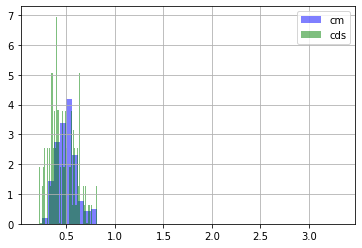

In [16]:
#dtm = 'circle'
#testmodel = '_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_rot_'+dtm+'_smr_nhc' + '_shift_kappa'
testmodel = '_mlp_1000_200-150-120_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_shift_kappa'
#testmodel = '_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_shift_kappa'
custom_object = {'custom_loss': custom_loss}

fortran_predictions = get_predictions(vector_cm, basepath=basepath, filename=testmodel, custom_object=custom_object)*faktor  # vector_last*faktor # 
fortran_predictions_2 = get_predictions(c_feat, basepath=basepath, filename=testmodel, custom_object=custom_object)*faktor
idx = list(range(0,9))

print(f'\nMittelwert/Standardabweichung cm:\t{np.mean(fortran_predictions):.4f},\t{np.std(fortran_predictions):.4f}')
print(f'Mittelwert/Standardabweichung c:\t{np.mean(fortran_predictions_2):.4f},\t{np.std(fortran_predictions_2):.4f}')
print(f'Mittelwert/Standardabweichung cds:\t{np.mean(vector_cds):.4f},\t{np.std(vector_cds):.4f}')

roud = 3
pd.Series(np.round(fortran_predictions, roud)).hist(bins=50, color='b', label='cm', alpha=0.5, density=True)
#pd.Series(np.round(fortran_predictions_2, roud)).hist(bins=50, color='r', label='c', alpha=0.5, density=True)
pd.Series(np.round(vector_cds, roud)).hist(bins=50, alpha=0.5, color='g', label='cds', density=True)

# Vergleich ml cds
# pd.Series(np.round(vector_last, roud)).hist(bins=50, alpha=1, color='b', label='ml')
# pd.Series(np.round(vector_cds, roud)).hist(bins=100, alpha=1, color='r', label='cds')
plt.legend()

#pd.Series(predictions_dg).hist(bins=50, alpha=0.5)

#ind = np.nonzero(fortran_predictions < 0.3)[0]
#test_features = vector_cm[ind , :]
#plot_vofs(np.reshape(c_feat, (c_feat.shape[0],7,7)), 5, labels=fortran_predictions[ind], per_row=5)
#print(test_features.shape)